# markov-transitions-roberta-base-mnli.ipynb

In [1]:
model_id = "textattack/roberta-base-MNLI"

In [3]:
# Add model_merging to the python path

import os
import sys

model_merging_base = os.path.abspath("../model_merging/")
# assert it exist
assert os.path.exists(model_merging_base)
if model_merging_base not in sys.path:
    sys.path.append(model_merging_base)

In [4]:
# import joblib for caching and distributed computing
from math import sqrt

from joblib import Memory, Parallel, delayed

memory = Memory(location="cache", verbose=10)

parallel = Parallel(n_jobs=2, return_as="generator")
output_generator = parallel(delayed(sqrt)(i**2) for i in range(10))

In [5]:
# Imports and cached functions

import os

from llm_weaver import (
    calculate_score_from_weaving_config,
    test_weaver,
)

# Disable parallelism in tokenizers to avoid deadlocks
os.environ["TOKENIZERS_PARALLELISM"] = "false"

calculate_score_from_weaving_config_cached = memory.cache(
    calculate_score_from_weaving_config
)
test_weaver_cached = memory.cache(test_weaver)

## Step 0: Test weaving code

This test makes sure that our score when using the weaver to reconstruct a model from all its parts get the same evaluation score as the original model

## Steps: configs to graph


In [21]:
from llm_weaver import dict_overwrite, get_model_config, normalize_glue_task_name


def transitions_weave_configs_iter(model_id, trajectories=None, max_configs=None):
    num_original_layers = get_model_config(model_id)["num_hidden_layers"]

    if trajectories is None:
        x_y_layer_sequences = [
            (x, y, (list(range(0, x + 1)) + list(range(y, num_original_layers))))
            for x in range(num_original_layers)
            for y in range(num_original_layers)
        ]
    else:
        x_y_layer_sequences = [(None, None, trajectory) for trajectory in trajectories]

    if max_configs is not None:
        x_y_layer_sequences = x_y_layer_sequences[:max_configs]
    for x, y, layer_sequence in x_y_layer_sequences:
        layer_assignments = [
            {
                "type": "SingleLayer",
                "params": {
                    "donor": model_id,
                    "hidden_layer_number": i,
                },
            }
            for i in layer_sequence
        ]

        blank_model_config = dict_overwrite(
            get_model_config(model_id),
            {
                "num_hidden_layers": len(layer_assignments),
            },
        )
        config = {
            "glue_task": normalize_glue_task_name(model_id),
            "tokenizer_model_id": model_id,
            "blank_model_config": blank_model_config,
            "layer_assignments": layer_assignments,
            "classification_head": {
                "type": "SingleClassificationHead",
                "params": {
                    "donor": model_id,
                },
            },
            "embeddings": {
                "type": "SingleEmbeddings",
                "params": {
                    "donor": model_id,
                },
            },
            "metadata": {
                "x": x,
                "y": y,
            },
        }

        yield config


weave_configs = list(
    transitions_weave_configs_iter(
        model_id=model_id,
    )
)


len(weave_configs)

144

In [7]:
import pandas as pd

scores = Parallel(n_jobs=5, return_as="list")(
    delayed(calculate_score_from_weaving_config_cached)(
        weave_config,
        # n_examples=4096,
        n_examples=128,
        split="validation",
    )
    for weave_config in weave_configs
)
accuracies = [score["accuracy"] for score in scores]


records = []
for weave_config, accuracy in zip(weave_configs, accuracies):
    record = weave_config["metadata"]
    record["accuracy"] = accuracy
    records.append(record)
df_big_grid = pd.DataFrame.from_records(records)

[Memory]: Loading calculate_score_from_weaving_config from cache/joblib/llm_weaver/calculate_score_from_weaving_config/4506eab8a3eff3f66324a604c6abe4f2[Memory]: Loading calculate_score_from_weaving_config from cache/joblib/llm_weaver/calculate_score_from_weaving_config/6067d76aecbcee3cda0dcd629a8e9028

[Memory]: Loading calculate_score_from_weaving_config from cache/joblib/llm_weaver/calculate_score_from_weaving_config/5ce882b1e36fe8045ef3760bcc4bf8ce
[Memory]: Loading calculate_score_from_weaving_config from cache/joblib/llm_weaver/calculate_score_from_weaving_config/13382fc1f1ac043f87ad4a71f67a857f
_________________calculate_score_from_weaving_config cache loaded - 0.0s, 0.0min
_________________calculate_score_from_weaving_config cache loaded - 0.0s, 0.0min
_________________calculate_score_from_weaving_config cache loaded - 0.0s, 0.0min
[Memory]: Loading calculate_score_from_weaving_config from cache/joblib/llm_weaver/calculate_score_from_weaving_config/900919aa1194b998c790e93528b07a

<Axes: xlabel='y', ylabel='x'>

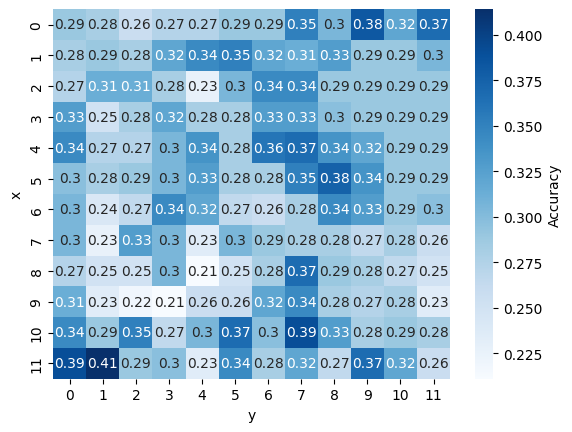

In [8]:
# Plot a heatmap of the accuracy with respect to the layer transitions
# x and y are the layer numbers of the first and last layer of the transition
# the color is the accuracy

import seaborn as sns

sns.heatmap(
    df_big_grid.pivot(index="x", columns="y", values="accuracy"),
    annot=True,
    # fmt=".0%",
    # do not show numbers in the heatmap
    # fmt=".0f",
    cmap="Blues",
    cbar_kws={"label": "Accuracy"},
)

In [23]:
# best score
best = df_big_grid[df_big_grid["accuracy"] == df_big_grid["accuracy"].max()]

best.x.values[0], best.y.values[0]
# get the weave config with the best score
best_weave_config = weave_configs[df_big_grid["accuracy"].idxmax()]

# get the best score using more samples
calculate_score_from_weaving_config_cached(
    best_weave_config,
    # n_examples=4096,
    n_examples=512,
    split="validation",
)

________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=512, split='validation')
calculating score for weaving config md5sum: 32263d4208308fd2b68eb4cd9301c7

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:221: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/model_merging/model_merging/evaluation.py:7: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  return hfds.load_metric("glue", task)
2023-11-28 07:40:41.092390: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpec

_____________________________calculate_score_from_weaving_config - 55.1s, 0.9min


{'accuracy': 0.427734375}

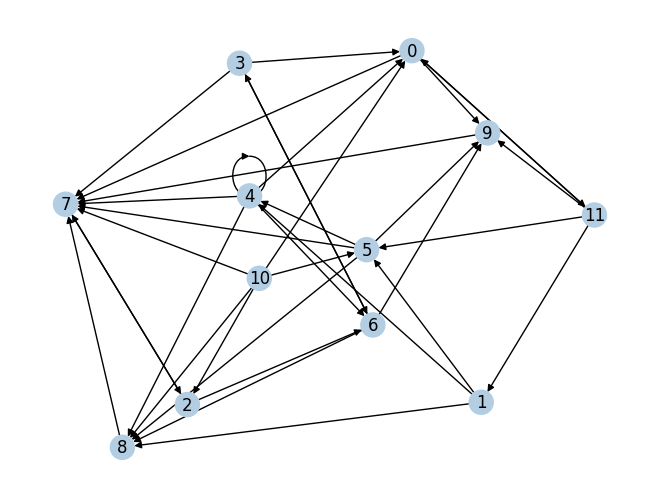

In [9]:
num_layers = get_model_config(model_id)["num_hidden_layers"]

import networkx as nx

G = nx.DiGraph()
G.add_nodes_from(range(num_layers))

weights = (
    df_big_grid.pivot(index="x", columns="y", values="accuracy").fillna(0).to_numpy()
)
max_weight = weights.max()

for x in range(num_layers):
    for y in range(num_layers):
        # if the weight is > 0.7, add the edge
        if weights[x][y] > max_weight - 0.09:
            G.add_edge(x, y, weight=weights[x][y])

# light blue nodes
node_colors = ["#b3cde3"] * num_layers
nx.draw(G, with_labels=True, node_color=node_colors)

In [10]:
# Sample trajectories
import random

random.seed(42)

trajectories_by_length = {}
for length in range(num_layers - 2, num_layers + 7):
    trajectories = []
    while len(trajectories) < 5:
        trajectory = [0]
        while trajectory[-1] != num_layers - 1:
            # Assume uniform distribution over neighbors
            trajectory.append(random.choice(list(G.neighbors(trajectory[-1]))))
        if len(trajectory) == length:
            trajectories.append(trajectory)
    trajectories_by_length[length] = trajectories

print(trajectories_by_length)

{10: [[0, 9, 7, 2, 6, 3, 6, 3, 0, 11], [0, 9, 7, 2, 6, 3, 6, 3, 0, 11], [0, 9, 7, 2, 7, 2, 6, 3, 0, 11], [0, 9, 7, 2, 7, 2, 6, 3, 0, 11], [0, 9, 7, 2, 7, 2, 6, 3, 0, 11]], 11: [[0, 7, 2, 6, 9, 7, 2, 6, 3, 0, 11], [0, 7, 2, 6, 9, 7, 2, 6, 3, 0, 11], [0, 7, 2, 7, 2, 7, 2, 6, 3, 0, 11], [0, 7, 2, 6, 8, 7, 2, 6, 3, 0, 11], [0, 7, 2, 6, 9, 7, 2, 6, 3, 0, 11]], 12: [[0, 9, 7, 2, 7, 2, 7, 2, 6, 3, 0, 11], [0, 9, 7, 2, 7, 2, 7, 2, 6, 3, 0, 11], [0, 9, 7, 2, 7, 2, 7, 2, 6, 3, 0, 11], [0, 9, 7, 2, 6, 3, 7, 2, 6, 3, 0, 11], [0, 9, 7, 2, 6, 8, 7, 2, 6, 3, 0, 11]], 13: [[0, 7, 2, 7, 2, 7, 2, 7, 2, 6, 3, 0, 11], [0, 7, 2, 6, 9, 7, 2, 6, 3, 6, 3, 0, 11], [0, 9, 7, 2, 6, 3, 0, 7, 2, 6, 3, 0, 11], [0, 7, 2, 7, 2, 6, 9, 7, 2, 6, 3, 0, 11], [0, 7, 2, 6, 8, 7, 2, 7, 2, 6, 3, 0, 11]], 14: [[0, 9, 7, 2, 7, 2, 7, 2, 7, 2, 6, 3, 0, 11], [0, 9, 7, 2, 6, 9, 7, 2, 7, 2, 6, 3, 0, 11], [0, 9, 7, 2, 6, 8, 7, 2, 7, 2, 6, 3, 0, 11], [0, 9, 7, 2, 7, 2, 6, 8, 7, 2, 6, 3, 0, 11], [0, 9, 7, 2, 6, 3, 6, 9, 7, 2, 6, 3, 0, 

In [11]:
records = []

for length, trajectories in trajectories_by_length.items():
    print(f"Length {length}")
    weave_configs = list(
        transitions_weave_configs_iter(model_id, trajectories=trajectories)
    )

    scores = Parallel(n_jobs=5, return_as="list")(
        delayed(calculate_score_from_weaving_config_cached)(
            weave_config,
            # n_examples=4096,
            n_examples=128,
            split="validation",
        )
        for weave_config in weave_configs
    )
    accuracies = [score["accuracy"] for score in scores]

    for trajectory, accuracy in zip(trajectories, accuracies):
        record = {}
        record["trajectory"] = trajectory
        record["accuracy"] = accuracy
        record["trajectory_length"] = len(trajectory)
        records.append(record)
df_transitions = pd.DataFrame.from_records(records)
df_transitions

Length 10
[Memory]: Loading calculate_score_from_weaving_config from cache/joblib/llm_weaver/calculate_score_from_weaving_config/9d28ba3f7a7a89a9719dc9eb3f7fa5e3
_________________calculate_score_from_weaving_config cache loaded - 0.0s, 0.0min
[Memory]: Loading calculate_score_from_weaving_config from cache/joblib/llm_weaver/calculate_score_from_weaving_config/9d28ba3f7a7a89a9719dc9eb3f7fa5e3
_________________calculate_score_from_weaving_config cache loaded - 0.0s, 0.0min
[Memory]: Loading calculate_score_from_weaving_config from cache/joblib/llm_weaver/calculate_score_from_weaving_config/c514e9c3b162d62d52a0b1f9d4acce74
_________________calculate_score_from_weaving_config cache loaded - 0.0s, 0.0min
[Memory]: Loading calculate_score_from_weaving_config from cache/joblib/llm_weaver/calculate_score_from_weaving_config/c514e9c3b162d62d52a0b1f9d4acce74
_________________calculate_score_from_weaving_config cache loaded - 0.0s, 0.0min
[Memory]: Loading calculate_score_from_weaving_config from

,trajectory,accuracy,trajectory_length
0,"[0, 9, 7, 2, 6, 3, 6, 3, 0, 11]",0.351562,10
1,"[0, 9, 7, 2, 6, 3, 6, 3, 0, 11]",0.351562,10
2,"[0, 9, 7, 2, 7, 2, 6, 3, 0, 11]",0.320312,10
3,"[0, 9, 7, 2, 7, 2, 6, 3, 0, 11]",0.320312,10
4,"[0, 9, 7, 2, 7, 2, 6, 3, 0, 11]",0.320312,10
5,"[0, 7, 2, 6, 9, 7, 2, 6, 3, 0, 11]",0.289062,11
6,"[0, 7, 2, 6, 9, 7, 2, 6, 3, 0, 11]",0.289062,11
7,"[0, 7, 2, 7, 2, 7, 2, 6, 3, 0, 11]",0.273438,11
8,"[0, 7, 2, 6, 8, 7, 2, 6, 3, 0, 11]",0.312500,11
9,"[0, 7, 2, 6, 9, 7, 2, 6, 3, 0, 11]",0.289062,11


<Axes: xlabel='trajectory_length', ylabel='accuracy'>

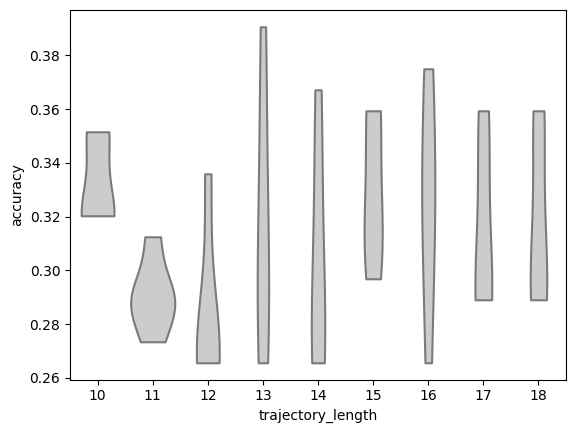

In [12]:
# Show a violin plot of the distribution of accuracies for each trajectory length
sns.violinplot(
    data=df_transitions,
    x="trajectory_length",
    y="accuracy",
    inner=None,
    color=".8",
    cut=0,
)